In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler, StandardScaler
from sklearn.model_selection import StratifiedKFold  
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.metrics import matthews_corrcoef

In [2]:
train = pd.read_csv(r"C:\Users\82109\OneDrive\바탕 화면\python study\daycon\여행 패키지\train.csv")
test = pd.read_csv(r"C:\Users\82109\OneDrive\바탕 화면\python study\daycon\여행 패키지\test.csv")

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1955 entries, 0 to 1954
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1955 non-null   int64  
 1   Age                       1861 non-null   float64
 2   TypeofContact             1945 non-null   object 
 3   CityTier                  1955 non-null   int64  
 4   DurationOfPitch           1853 non-null   float64
 5   Occupation                1955 non-null   object 
 6   Gender                    1955 non-null   object 
 7   NumberOfPersonVisiting    1955 non-null   int64  
 8   NumberOfFollowups         1942 non-null   float64
 9   ProductPitched            1955 non-null   object 
 10  PreferredPropertyStar     1945 non-null   float64
 11  MaritalStatus             1955 non-null   object 
 12  NumberOfTrips             1898 non-null   float64
 13  Passport                  1955 non-null   int64  
 14  PitchSat

In [4]:
# target data 확인
np.unique(train.ProdTaken, return_counts = True)

(array([0, 1], dtype=int64), array([1572,  383], dtype=int64))

In [5]:
train.isna().sum()

id                            0
Age                          94
TypeofContact                10
CityTier                      0
DurationOfPitch             102
Occupation                    0
Gender                        0
NumberOfPersonVisiting        0
NumberOfFollowups            13
ProductPitched                0
PreferredPropertyStar        10
MaritalStatus                 0
NumberOfTrips                57
Passport                      0
PitchSatisfactionScore        0
OwnCar                        0
NumberOfChildrenVisiting     27
Designation                   0
MonthlyIncome               100
ProdTaken                     0
dtype: int64

In [6]:
test.isna().sum()

id                            0
Age                         132
TypeofContact                15
CityTier                      0
DurationOfPitch             149
Occupation                    0
Gender                        0
NumberOfPersonVisiting        0
NumberOfFollowups            32
ProductPitched                0
PreferredPropertyStar        16
MaritalStatus                 0
NumberOfTrips                83
Passport                      0
PitchSatisfactionScore        0
OwnCar                        0
NumberOfChildrenVisiting     39
Designation                   0
MonthlyIncome               133
dtype: int64

- object 타입 데이터 변환

In [7]:
object_columns = train.columns[train.dtypes == 'object']
print('object 칼럼은 다음과 같습니다 : ', list(object_columns))

# 해당 칼럼만 보아서 봅시다
train[object_columns]

object 칼럼은 다음과 같습니다 :  ['TypeofContact', 'Occupation', 'Gender', 'ProductPitched', 'MaritalStatus', 'Designation']


,TypeofContact,Occupation,Gender,ProductPitched,MaritalStatus,Designation
0,Company Invited,Small Business,Male,Basic,Married,Executive
1,Self Enquiry,Small Business,Female,Deluxe,Single,Manager
2,Company Invited,Salaried,Male,Deluxe,Married,Manager
3,Company Invited,Small Business,Male,Basic,Married,Executive
4,Self Enquiry,Salaried,Male,Deluxe,Divorced,Manager
...,...,...,...,...,...,...
1950,Self Enquiry,Small Business,Male,Basic,Single,Executive
1951,Self Enquiry,Salaried,Female,Super Deluxe,Divorced,AVP
1952,Company Invited,Small Business,Female,Basic,Divorced,Executive
1953,Self Enquiry,Small Business,Female,Deluxe,Married,Manager


In [8]:
train_enc = train.copy()

In [9]:
from sklearn.preprocessing import LabelEncoder

# 모든 문자형 변수에 대해 encoder를 적용합니다.
for o_col in object_columns:
    encoder = LabelEncoder()
    encoder.fit(train[o_col])
    train[o_col] = encoder.transform(train[o_col])

# 결과를 확인합니다.
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1955 entries, 0 to 1954
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        1955 non-null   int64  
 1   Age                       1861 non-null   float64
 2   TypeofContact             1955 non-null   int32  
 3   CityTier                  1955 non-null   int64  
 4   DurationOfPitch           1853 non-null   float64
 5   Occupation                1955 non-null   int32  
 6   Gender                    1955 non-null   int32  
 7   NumberOfPersonVisiting    1955 non-null   int64  
 8   NumberOfFollowups         1942 non-null   float64
 9   ProductPitched            1955 non-null   int32  
 10  PreferredPropertyStar     1945 non-null   float64
 11  MaritalStatus             1955 non-null   int32  
 12  NumberOfTrips             1898 non-null   float64
 13  Passport                  1955 non-null   int64  
 14  PitchSat

Text(0.5, 1.0, 'correlation between columns')

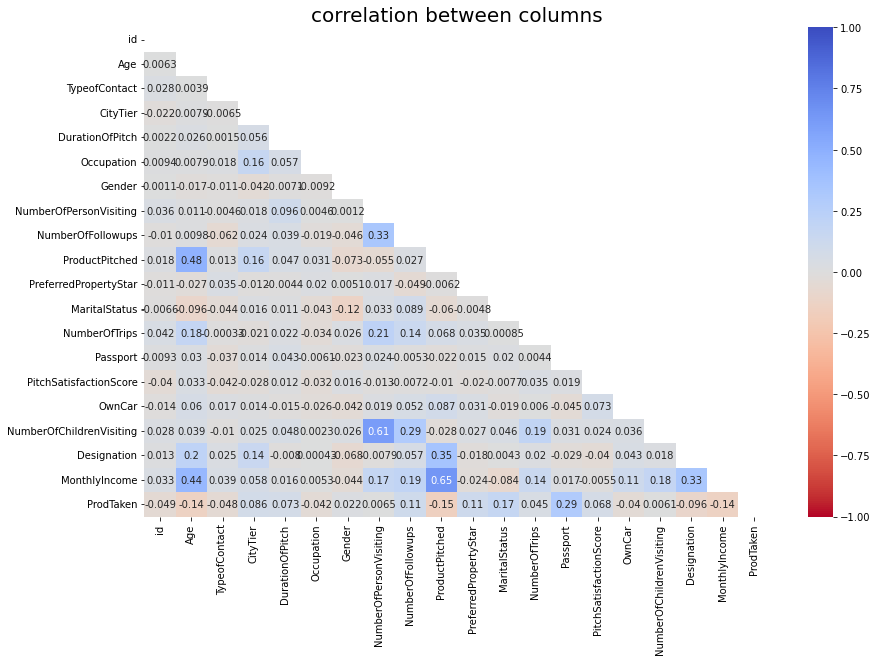

In [10]:
# 상관관계 분석도
plt.figure(figsize=(14, 9))
heat_table = train.corr()
mask = np.zeros_like(heat_table) # np.zeros_like : 어떤 변수만큼의 사이즈인 0 으로 가득 찬 Array를 배출한다
mask[np.triu_indices_from(mask)]=True # 삼각형으로 표시 
heatmap_ax = sns.heatmap(heat_table, annot=True, mask=mask, cmap='coolwarm_r', vmin=-1, vmax=1)
heatmap_ax.set_xticklabels(heatmap_ax.get_xticklabels(), fontsize=10, rotation=90)
heatmap_ax.set_yticklabels(heatmap_ax.get_yticklabels(), fontsize=10)
plt.title('correlation between columns', fontsize=20)

- 수치가 애매한 'Gender', 'OwnCar'의 여행 신청 여부 확인

[Text(0.5, 1.0, 'Gender')]

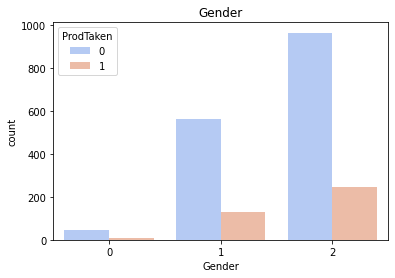

In [11]:
palette = sns.color_palette('coolwarm', 2)
sns.countplot(x='Gender', hue='ProdTaken', data=train, palette=palette).set(title='Gender')  

- 남성 비율이 많고 여행신청 비율은 여성과 비슷하다.

[Text(0.5, 1.0, 'OwnCar')]

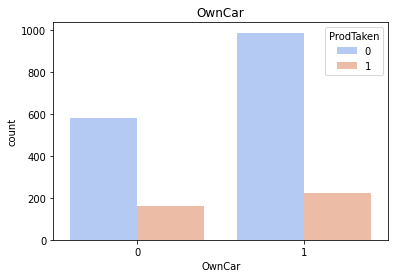

In [12]:
sns.countplot(x='OwnCar', hue='ProdTaken',  data=train, palette=palette).set(title='OwnCar')  

- 자동차 보유자의 비율이 크지만 여행신청 비율은 미보유자와 큰 차이가 없다.

In [13]:
train.describe()

,id,Age,TypeofContact,CityTier,DurationOfPitch,Occupation,Gender,NumberOfPersonVisiting,NumberOfFollowups,ProductPitched,PreferredPropertyStar,MaritalStatus,NumberOfTrips,Passport,PitchSatisfactionScore,OwnCar,NumberOfChildrenVisiting,Designation,MonthlyIncome,ProdTaken
count,1955.000000,1861.000000,1955.000000,1955.000000,1853.000000,1955.000000,1955.000000,1955.000000,1942.000000,1955.000000,1945.000000,1955.000000,1898.000000,1955.000000,1955.000000,1955.000000,1928.000000,1955.000000,1855.000000,1955.000000
mean,978.000000,37.462117,0.715601,1.641432,15.524015,2.338107,1.588747,2.922762,3.718332,1.172890,3.568638,1.275192,3.255532,0.291049,3.067519,0.619437,1.213174,1.731458,23624.108895,0.195908
std,564.504207,9.189948,0.462445,0.908744,8.150057,0.627545,0.547326,0.712276,1.004095,1.270394,0.793196,0.933826,1.814698,0.454362,1.372915,0.485649,0.859450,0.954978,5640.482258,0.397000
min,1.000000,18.000000,0.000000,1.000000,5.000000,0.000000,0.000000,1.000000,1.000000,0.000000,3.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1000.000000,0.000000
25%,489.500000,31.000000,0.000000,1.000000,9.000000,2.000000,1.000000,2.000000,3.000000,0.000000,3.000000,1.000000,2.000000,0.000000,2.000000,0.000000,1.000000,1.000000,20390.000000,0.000000
50%,978.000000,36.000000,1.000000,1.000000,14.000000,2.000000,2.000000,3.000000,4.000000,1.000000,3.000000,1.000000,3.000000,0.000000,3.000000,1.000000,1.000000,2.000000,22295.000000,0.000000
75%,1466.500000,43.000000,1.000000,3.000000,20.000000,3.000000,2.000000,3.000000,4.000000,2.000000,4.000000,2.000000,4.000000,1.000000,4.000000,1.000000,2.000000,2.000000,25558.000000,0.000000
max,1955.000000,61.000000,2.000000,3.000000,36.000000,3.000000,2.000000,5.000000,6.000000,4.000000,5.000000,3.000000,19.000000,1.000000,5.000000,1.000000,3.000000,4.000000,98678.000000,1.000000


In [14]:
# min, max가 평균과 크게 차이나는 'NumberOfTrips', 'MonthlyIncome' 데이터 이상치 확인
# 'MonthlyIncome' 상관계수 확인
train.corrwith(train['MonthlyIncome'])

id                          0.032920
Age                         0.440733
TypeofContact               0.039107
CityTier                    0.057705
DurationOfPitch             0.016011
Occupation                  0.005325
Gender                     -0.043840
NumberOfPersonVisiting      0.168701
NumberOfFollowups           0.194668
ProductPitched              0.648318
PreferredPropertyStar      -0.024338
MaritalStatus              -0.083679
NumberOfTrips               0.137093
Passport                    0.017044
PitchSatisfactionScore     -0.005497
OwnCar                      0.109662
NumberOfChildrenVisiting    0.179255
Designation                 0.331735
MonthlyIncome               1.000000
ProdTaken                  -0.140617
dtype: float64

- 영업사원이 제시한 상품이 좋을수록, 직급이 높을수록 월급이 높다

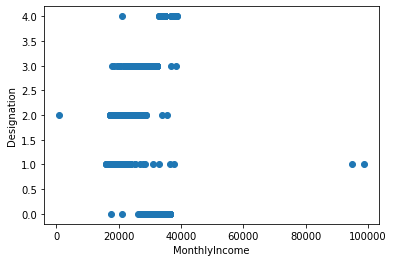

In [15]:
# 'MonthlyIncom' 이상치 확인
plt.scatter(train.MonthlyIncome, train.Designation)
plt.xlabel('MonthlyIncome')
plt.ylabel('Designation')
plt.show()

In [16]:
# 이상치 인덱스 확인
train['MonthlyIncome'].sort_values(ascending=False)

1338    98678.0
604     95000.0
827     38651.0
1518    38604.0
314     38537.0
         ...   
1897        NaN
1911        NaN
1912        NaN
1914        NaN
1923        NaN
Name: MonthlyIncome, Length: 1955, dtype: float64

In [17]:
# 이상치 인덱스 확인
train['MonthlyIncome'].sort_values()

189      1000.0
838     16009.0
538     16052.0
1505    16091.0
73      16118.0
         ...   
1897        NaN
1911        NaN
1912        NaN
1914        NaN
1923        NaN
Name: MonthlyIncome, Length: 1955, dtype: float64

- 1338, 604, 189번

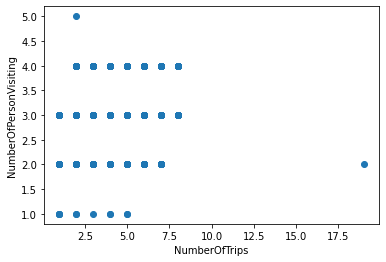

In [18]:
# 'NumberOfTrips' 이상치 확인
plt.scatter(train.NumberOfTrips, train.NumberOfPersonVisiting)
plt.xlabel('NumberOfTrips')
plt.ylabel('NumberOfPersonVisiting')
plt.show()

In [19]:
train['NumberOfTrips'].sort_values(ascending=False) # 987번

987     19.0
1828     8.0
303      8.0
1404     8.0
1598     8.0
        ... 
1822     NaN
1856     NaN
1899     NaN
1906     NaN
1927     NaN
Name: NumberOfTrips, Length: 1955, dtype: float64

- 이상치 제거

In [20]:
train.drop(index=[189, 604, 987, 1338], inplace=True)

- 결측치 처리

In [21]:
# 'TypeofContact'은 Unknown(0), 'DurationOfPitch'는 기간(0)으로 판단하고 처리

ls = ['DurationOfPitch', 'TypeofContact']
for these in [train, test]:
    for col in ls:
        these[col].fillna(0, inplace=True)
        
# 'PreferredPropertyStar', 'NumberOfTrips', 'Age'는 상관계수가 높은 컬럼의 그룹별 평균값으로 처리

for these in [train, test]:
    these['PreferredPropertyStar'].fillna(these.groupby('NumberOfTrips')['PreferredPropertyStar'].transform('mean'),inplace=True)
    these['NumberOfTrips'].fillna(these.groupby('DurationOfPitch')['NumberOfTrips'].transform('mean'),inplace=True)
    these['Age'].fillna(these.groupby('Designation')['Age'].transform('mean'),inplace=True)

In [22]:
train.isna().sum()

id                            0
Age                           0
TypeofContact                 0
CityTier                      0
DurationOfPitch               0
Occupation                    0
Gender                        0
NumberOfPersonVisiting        0
NumberOfFollowups            13
ProductPitched                0
PreferredPropertyStar         0
MaritalStatus                 0
NumberOfTrips                 0
Passport                      0
PitchSatisfactionScore        0
OwnCar                        0
NumberOfChildrenVisiting     27
Designation                   0
MonthlyIncome               100
ProdTaken                     0
dtype: int64

#### RobustScaler
- sklearn.preprocessiong.RobustScaler
- 평균과 분산 대신에 중간값과 사분위값 사용
- outlier의 영향을 최소화

In [23]:
# 비교적 값이 큰 데이터 스케일링
scaler = RobustScaler()
train[['Age', 'DurationOfPitch']] = scaler.fit_transform(train[['Age', 'DurationOfPitch']])
test[['Age', 'DurationOfPitch']] = scaler.fit_transform(test[['Age', 'DurationOfPitch']])

- 상관관계가 낮은 'NumberOfChildrenVisiting','NumberOfPersonVisiting' 제거
- 'OwnCar'은 자동차 보유자와 미보유자의 차이는 큰 반면 여행신청 비율은 큰 차이가 나지 않아 제거
- MonthlyIncome'은 결측치가 많고 'Age', 'DurationOfPitch', 'Designation' 등의 컬럼으로 충분히 대체가 될거라 판단
- 'NumberOfFollowups'은 불필요하다고 판단한 위의 컬럼들과 상관계수가 높고 다른 컬럼들과는 상관계수가 낮아 제거

In [24]:
# 중요도 낮다고 판단한 칼럼 제거하고 train_data를 x,y로 분리
train.drop(columns=['id', 'NumberOfChildrenVisiting','NumberOfPersonVisiting', 'OwnCar', 'MonthlyIncome', 'NumberOfFollowups'], axis=1, inplace=True)
test.drop(columns=['id', 'NumberOfChildrenVisiting','NumberOfPersonVisiting', 'OwnCar', 'MonthlyIncome', 'NumberOfFollowups'], axis=1, inplace=True)

x = train.drop(columns=['ProdTaken'], axis=1)
y = train[['ProdTaken']]

In [27]:
# k-fold
k_fold = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [28]:
# CatBoostClassifier 정의, 훈련
cat_params = {
    # 'depth': [10, 11, 14, 15],
    'l2_leaf_reg': [9.122611898980937],    
    'learning_rate': [0.279118773316628],
    'model_size_reg': [5.669787571831169],
    # 'n_estimators': [200, 300, 400, 500, 600],
    'od_pval': [0.0],
}   
# 하이퍼파라미터는 BayesianOptimization을 이용해 적절한 파라미터를 찾고, 최종적으로 GridSearchCV를 이용해 'depth'와 'n_estimators'를 조절하며 최선의 하이퍼파라미터를 찾았습니다.

cat = CatBoostClassifier(verbose=2, depth=14, n_estimators=200, allow_writing_files=False)  
grid_cv = GridSearchCV(cat,
                       param_grid=cat_params,
                       cv=k_fold,
                       n_jobs=-1)

grid_cv.fit(x, y.values.ravel())

model = grid_cv.best_estimator_
model.fit(x, y.values.ravel())

grid_cv.best_score_

0:	learn: 0.5279152	total: 165ms	remaining: 32.7s
2:	learn: 0.3971030	total: 254ms	remaining: 16.7s
4:	learn: 0.3086446	total: 267ms	remaining: 10.4s
6:	learn: 0.2497581	total: 351ms	remaining: 9.67s
8:	learn: 0.2088368	total: 446ms	remaining: 9.47s
10:	learn: 0.1848416	total: 489ms	remaining: 8.4s
12:	learn: 0.1588575	total: 572ms	remaining: 8.23s
14:	learn: 0.1387843	total: 662ms	remaining: 8.17s
16:	learn: 0.1278082	total: 717ms	remaining: 7.72s
18:	learn: 0.1141061	total: 791ms	remaining: 7.54s
20:	learn: 0.1026562	total: 880ms	remaining: 7.5s
22:	learn: 0.0934887	total: 963ms	remaining: 7.41s
24:	learn: 0.0855048	total: 1.03s	remaining: 7.25s
26:	learn: 0.0783911	total: 1.07s	remaining: 6.89s
28:	learn: 0.0724355	total: 1.17s	remaining: 6.88s
30:	learn: 0.0676823	total: 1.25s	remaining: 6.82s
32:	learn: 0.0634560	total: 1.34s	remaining: 6.78s
34:	learn: 0.0597251	total: 1.44s	remaining: 6.78s
36:	learn: 0.0562662	total: 1.53s	remaining: 6.73s
38:	learn: 0.0531624	total: 1.62s	rema

120:	learn: 0.0163237	total: 5.49s	remaining: 3.58s
122:	learn: 0.0160555	total: 5.58s	remaining: 3.5s
124:	learn: 0.0157907	total: 5.69s	remaining: 3.42s
126:	learn: 0.0155254	total: 5.8s	remaining: 3.33s
128:	learn: 0.0152664	total: 5.89s	remaining: 3.24s
130:	learn: 0.0150188	total: 5.99s	remaining: 3.16s
132:	learn: 0.0147853	total: 6.09s	remaining: 3.07s
134:	learn: 0.0145373	total: 6.18s	remaining: 2.98s
136:	learn: 0.0143047	total: 6.28s	remaining: 2.89s
138:	learn: 0.0140963	total: 6.37s	remaining: 2.8s
140:	learn: 0.0138886	total: 6.46s	remaining: 2.7s
142:	learn: 0.0136856	total: 6.56s	remaining: 2.61s
144:	learn: 0.0134965	total: 6.66s	remaining: 2.53s
146:	learn: 0.0133187	total: 6.75s	remaining: 2.43s
148:	learn: 0.0131354	total: 6.83s	remaining: 2.34s
150:	learn: 0.0129549	total: 6.93s	remaining: 2.25s
152:	learn: 0.0127851	total: 7.01s	remaining: 2.15s
154:	learn: 0.0126230	total: 7.09s	remaining: 2.06s
156:	learn: 0.0124443	total: 7.17s	remaining: 1.96s
158:	learn: 0.01

0.9390240711669282

In [ ]:
# 제출
y_summit = model.predict(test)
sample_submission['ProdTaken'] = y_summit
sample_submission.to_csv(, index=False)
np.unique(y_summit, return_counts=True)